# GravNet toy: instance clustering (4 blobs + noise)

Goal: **instance clustering**. Each event contains multiple Gaussian blobs (clusters) and uniform noise.
We train a GravNet-based network to predict whether **pairs of nearby points belong to the same cluster** (edge classification).
At inference, we build a graph of high-probability "same-cluster" edges and extract connected components as predicted clusters.

This avoids the ill-posed setup of fixed K-way classification when cluster IDs are arbitrary per event.


## Setup notes

This notebook uses:
- PyTorch
- PyTorch Geometric (GravNetConv)
- (Optional) `torch_geometric.nn.knn_graph` (requires torch-cluster)
- matplotlib

If `knn_graph` is unavailable, the notebook falls back to a pure-PyTorch kNN routine (slower).


In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GravNetConv

# Try to use PyG/torch_cluster kNN utilities if available
try:
    from torch_geometric.nn import knn_graph
    _HAS_KNN_GRAPH = True
except Exception:
    _HAS_KNN_GRAPH = False

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("knn_graph available:", _HAS_KNN_GRAPH)


/workspaces/mpetren-msceng-ldmx/.venv-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.8.0+cpu
cuda available: False
knn_graph available: True


## Synthetic event generator (instance IDs)

Labels:
- `cid` (cluster id) is **instance id within the event**: 0..K-1 for blobs, and -1 for noise.

Node features:
- `x, y, energy` where energy is correlated with proximity to the blob center (helps learning).


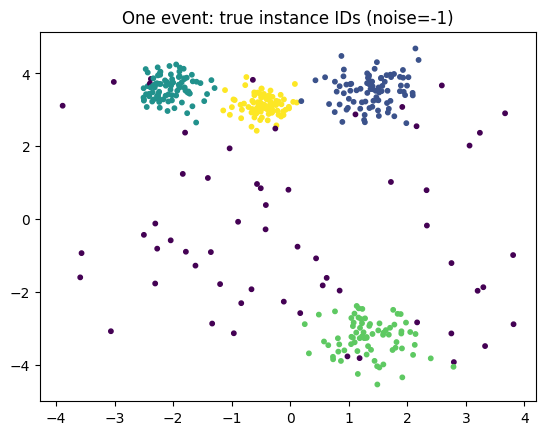

In [2]:
def make_blob_event_instance(
    n_points=400,
    n_clusters=4,
    noise_frac=0.15,
    sigma_range=(0.18, 0.55),
    center_range=(-4.0, 4.0),
    energy_range=(0.8, 2.0),
    seed=None,
):
    # Returns a PyG Data object with:
    #   x: [N,3] float32 (x,y,energy)
    #   cid: [N] int64 in {0..K-1} for blobs and -1 for noise

    rng = np.random.default_rng(seed)

    n_noise = int(round(n_points * noise_frac))
    n_signal = n_points - n_noise
    counts = rng.multinomial(n_signal, np.ones(n_clusters) / n_clusters)

    xs = []
    cids = []

    centers = rng.uniform(center_range[0], center_range[1], size=(n_clusters, 2)).astype(np.float32)
    sigmas = rng.uniform(sigma_range[0], sigma_range[1], size=(n_clusters,)).astype(np.float32)

    for k in range(n_clusters):
        cx, cy = centers[k]
        s = float(sigmas[k])
        pts = rng.normal(loc=(cx, cy), scale=s, size=(counts[k], 2)).astype(np.float32)

        # energy peaks at center and decays with radius
        r = np.sqrt((pts[:, 0] - cx) ** 2 + (pts[:, 1] - cy) ** 2)
        e = (rng.uniform(energy_range[0], energy_range[1], size=(counts[k],)).astype(np.float32)
             * np.exp(-0.5 * (r / (s + 1e-6)) ** 2).astype(np.float32))

        xs.append(np.column_stack([pts, e]).astype(np.float32))
        cids.append(np.full((counts[k],), k, dtype=np.int64))

    # noise: uniform in square, lower energy on average
    noise_xy = rng.uniform(center_range[0], center_range[1], size=(n_noise, 2)).astype(np.float32)
    noise_e = (rng.uniform(0.0, 1.0, size=(n_noise,)).astype(np.float32) * 0.6)
    xs.append(np.column_stack([noise_xy, noise_e]).astype(np.float32))
    cids.append(np.full((n_noise,), -1, dtype=np.int64))

    x = np.concatenate(xs, axis=0)
    cid = np.concatenate(cids, axis=0)

    perm = rng.permutation(x.shape[0])
    x = x[perm]
    cid = cid[perm]

    return Data(x=torch.from_numpy(x), cid=torch.from_numpy(cid))


# Quick visualization of one event (true instance IDs)
evt = make_blob_event_instance(seed=12345)
xy = evt.x[:, :2].numpy()
cid = evt.cid.numpy()

plt.figure()
plt.scatter(xy[:,0], xy[:,1], c=cid, s=10)
plt.title("One event: true instance IDs (noise=-1)")
plt.show()


## Dataset + normalization

We normalize `x` features using the training set mean/std.


In [3]:
def make_dataset(n_events, seed=0, **kwargs):
    rng = np.random.default_rng(seed)
    out = []
    for _ in range(n_events):
        out.append(make_blob_event_instance(seed=int(rng.integers(0, 2**31-1)), **kwargs))
    return out

train_data = make_dataset(2000, seed=1, n_points=400, n_clusters=4, noise_frac=0.15)
val_data   = make_dataset( 400, seed=2, n_points=400, n_clusters=4, noise_frac=0.15)

# compute normalization stats from training set
X = torch.cat([d.x.float() for d in train_data], dim=0)
x_mean = X.mean(dim=0)
x_std  = X.std(dim=0).clamp_min(1e-6)

for d in train_data:
    d.x = (d.x.float() - x_mean) / x_std
for d in val_data:
    d.x = (d.x.float() - x_mean) / x_std

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=0)

x_mean, x_std


(tensor([-0.0034, -0.0402,  0.6398]), tensor([2.3373, 2.3278, 0.4449]))

## Building training edges

We train on **k-nearest-neighbor edges** computed in the *input* (x,y) space (after normalization).
For each directed edge (i→j):
- target = 1 if `cid[i] == cid[j]` and both are not noise
- else 0

We also include a **node noise head** to predict noise vs signal.


In [4]:
def knn_edges_pure_torch(xy, batch, k):
    # Slow fallback if knn_graph isn't available.
    device = xy.device
    edge_src = []
    edge_dst = []

    batch = batch.to(device)
    for b in batch.unique(sorted=True):
        mask = (batch == b)
        idx = mask.nonzero(as_tuple=False).view(-1)
        pts = xy[idx]  # [M,2]
        M = pts.size(0)
        if M <= 1:
            continue

        d2 = torch.cdist(pts, pts, p=2)  # [M,M]
        kk = min(k+1, M)
        nn = torch.topk(d2, k=kk, largest=False).indices
        nn = nn[:, 1:kk]  # drop self

        src_local = torch.arange(M, device=device).unsqueeze(1).repeat(1, nn.size(1)).reshape(-1)
        dst_local = nn.reshape(-1)

        edge_src.append(idx[src_local])
        edge_dst.append(idx[dst_local])

    if len(edge_src) == 0:
        return torch.empty((2,0), dtype=torch.long, device=device)
    return torch.stack([torch.cat(edge_src), torch.cat(edge_dst)], dim=0)


def build_edge_index(data, k=12):
    xy = data.x[:, :2]
    batch = data.batch
    if _HAS_KNN_GRAPH:
        return knn_graph(xy, k=k, batch=batch, loop=False)
    return knn_edges_pure_torch(xy, batch, k=k)


## Model: GravNet backbone + edge head + noise head

- Backbone produces node embeddings `z_i`.
- Edge head predicts `p(same_cluster | i,j)` for kNN edges.
- Noise head predicts `p(noise | i)` for nodes.


In [5]:
class GravNetEdgeNet(nn.Module):
    def __init__(self, in_dim=3, hidden=96, space_dim=3, prop_dim=48, k=12, dropout=0.1):
        super().__init__()
        self.k = k

        self.pre = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(dropout),
        )

        self.gn1 = GravNetConv(hidden, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)
        self.gn2 = GravNetConv(hidden, hidden, space_dimensions=space_dim, propagate_dimensions=prop_dim, k=k)

        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn2 = nn.BatchNorm1d(hidden)

        self.edge_mlp = nn.Sequential(
            nn.Linear(3*hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),
        )

        self.noise_mlp = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1),
        )

    def forward(self, data):
        x = self.pre(data.x)
        batch = data.batch

        x = self.gn1(x, batch)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.gn2(x, batch)
        x = self.bn2(x)
        x = F.relu(x)

        z = x

        edge_index = build_edge_index(data, k=self.k)
        src, dst = edge_index[0], edge_index[1]
        zi, zj = z[src], z[dst]
        feat = torch.cat([zi, zj, (zi - zj).abs()], dim=-1)
        edge_logits = self.edge_mlp(feat).squeeze(-1)  # [E]

        noise_logits = self.noise_mlp(z).squeeze(-1)   # [N]
        return z, edge_index, edge_logits, noise_logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GravNetEdgeNet(in_dim=3, hidden=96, space_dim=3, prop_dim=48, k=12, dropout=0.1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)

model


GravNetEdgeNet(
  (pre): Sequential(
    (0): Linear(in_features=3, out_features=96, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (gn1): GravNetConv(96, 96, k=12)
  (gn2): GravNetConv(96, 96, k=12)
  (bn1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (edge_mlp): Sequential(
    (0): Linear(in_features=288, out_features=96, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=96, out_features=1, bias=True)
  )
  (noise_mlp): Sequential(
    (0): Linear(in_features=96, out_features=48, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=48, out_features=1, bias=True)
  )
)

## Training and evaluation

Loss:
- BCE(edge logits, edge targets)
- BCE(noise logits, noise targets)

We also compute a clustering metric per event:
- ARI (Adjusted Rand Index), excluding noise points.


In [6]:
def edge_targets(data, edge_index):
    cid = data.cid
    src, dst = edge_index[0], edge_index[1]
    ci, cj = cid[src], cid[dst]
    same = (ci == cj) & (ci != -1) & (cj != -1)
    return same.float()

def noise_targets(data):
    return (data.cid == -1).float()

@torch.no_grad()
def edge_accuracy(edge_logits, y_edge):
    pred = (torch.sigmoid(edge_logits) > 0.5).float()
    return (pred == y_edge).float().mean().item()

@torch.no_grad()
def node_accuracy(noise_logits, y_noise):
    pred = (torch.sigmoid(noise_logits) > 0.5).float()
    return (pred == y_noise).float().mean().item()


In [7]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0]*n

    def find(self, a):
        while self.parent[a] != a:
            self.parent[a] = self.parent[self.parent[a]]
            a = self.parent[a]
        return a

    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components_from_edges(n_nodes, edge_index, edge_prob, thresh=0.5):
    uf = UnionFind(n_nodes)
    src = edge_index[0].cpu().numpy()
    dst = edge_index[1].cpu().numpy()
    keep = (edge_prob.cpu().numpy() > thresh)
    for i, j, k in zip(src, dst, keep):
        if k:
            uf.union(int(i), int(j))
    roots = [uf.find(i) for i in range(n_nodes)]
    uniq = {}
    out = np.zeros(n_nodes, dtype=np.int64)
    c = 0
    for i, r in enumerate(roots):
        if r not in uniq:
            uniq[r] = c
            c += 1
        out[i] = uniq[r]
    return out


In [8]:
def ari_score(labels_true, labels_pred):
    lt = np.asarray(labels_true, dtype=np.int64)
    lp = np.asarray(labels_pred, dtype=np.int64)
    n = lt.size
    if n == 0:
        return 0.0

    _, lt = np.unique(lt, return_inverse=True)
    _, lp = np.unique(lp, return_inverse=True)

    k1 = lt.max() + 1
    k2 = lp.max() + 1
    cont = np.zeros((k1, k2), dtype=np.int64)
    for a, b in zip(lt, lp):
        cont[a, b] += 1

    def comb2(x): return x*(x-1)//2

    sum_comb_c = sum(comb2(v) for v in cont.ravel())
    sum_comb_r = sum(comb2(v) for v in cont.sum(axis=1))
    sum_comb_k = sum(comb2(v) for v in cont.sum(axis=0))
    comb_n = comb2(n)

    if comb_n == 0:
        return 0.0

    expected = (sum_comb_r * sum_comb_k) / comb_n
    max_index = 0.5*(sum_comb_r + sum_comb_k)
    denom = max_index - expected
    if denom == 0:
        return 0.0
    return float((sum_comb_c - expected) / denom)


In [9]:
def train_one_epoch(model, loader, opt, lambda_edge=1.0, lambda_noise=1.0):
    model.train()
    total_loss = 0.0
    total_eacc = 0.0
    total_nacc = 0.0
    steps = 0

    for data in loader:
        data = data.to(device)
        opt.zero_grad(set_to_none=True)

        z, edge_index, edge_logits, noise_logits = model(data)

        y_edge = edge_targets(data, edge_index)
        y_noise = noise_targets(data)

        loss_edge = F.binary_cross_entropy_with_logits(edge_logits, y_edge)
        loss_noise = F.binary_cross_entropy_with_logits(noise_logits, y_noise)
        loss = lambda_edge*loss_edge + lambda_noise*loss_noise

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()

        with torch.no_grad():
            total_loss += loss.item()
            total_eacc += edge_accuracy(edge_logits, y_edge)
            total_nacc += node_accuracy(noise_logits, y_noise)
            steps += 1

    return total_loss/steps, total_eacc/steps, total_nacc/steps


@torch.no_grad()
def evaluate(model, loader, edge_thresh=0.6):
    model.eval()
    total_loss = 0.0
    total_eacc = 0.0
    total_nacc = 0.0
    total_ari = 0.0
    steps = 0

    for data in loader:
        data = data.to(device)
        z, edge_index, edge_logits, noise_logits = model(data)

        y_edge = edge_targets(data, edge_index)
        y_noise = noise_targets(data)

        loss_edge = F.binary_cross_entropy_with_logits(edge_logits, y_edge)
        loss_noise = F.binary_cross_entropy_with_logits(noise_logits, y_noise)
        loss = loss_edge + loss_noise

        edge_prob = torch.sigmoid(edge_logits)
        batch = data.batch.detach().cpu().numpy()
        cid = data.cid.detach().cpu().numpy()

        comp = connected_components_from_edges(data.num_nodes, edge_index, edge_prob, thresh=edge_thresh)

        ari_sum = 0.0
        n_events = int(batch.max()) + 1 if data.num_nodes > 0 else 0
        for b in range(n_events):
            m = (batch == b)
            sig = m & (cid != -1)
            if sig.sum() < 2:
                continue
            ari_sum += ari_score(cid[sig], comp[sig])

        ari_avg = ari_sum / max(1, n_events)

        total_loss += loss.item()
        total_eacc += edge_accuracy(edge_logits, y_edge)
        total_nacc += node_accuracy(noise_logits, y_noise)
        total_ari += ari_avg
        steps += 1

    return total_loss/steps, total_eacc/steps, total_nacc/steps, total_ari/steps


EPOCHS = 25
best = float("inf")
best_state = None

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_eacc, tr_nacc = train_one_epoch(model, train_loader, opt)
    va_loss, va_eacc, va_nacc, va_ari = evaluate(model, val_loader, edge_thresh=0.6)

    if va_loss < best:
        best = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch == 1 or epoch % 5 == 0:
        print(f"epoch {epoch:02d} | "
              f"train loss {tr_loss:.4f} edge_acc {tr_eacc:.3f} noise_acc {tr_nacc:.3f} | "
              f"val loss {va_loss:.4f} edge_acc {va_eacc:.3f} noise_acc {va_nacc:.3f} ARI {va_ari:.3f}")

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


epoch 01 | train loss 0.6624 edge_acc 0.861 noise_acc 0.864 | val loss 0.3870 edge_acc 0.911 noise_acc 0.963 ARI 0.655
epoch 05 | train loss 0.3313 edge_acc 0.921 noise_acc 0.966 | val loss 0.3193 edge_acc 0.925 noise_acc 0.971 ARI 0.638
epoch 10 | train loss 0.3033 edge_acc 0.926 noise_acc 0.968 | val loss 0.3030 edge_acc 0.926 noise_acc 0.972 ARI 0.648
epoch 15 | train loss 0.2909 edge_acc 0.928 noise_acc 0.969 | val loss 0.2775 edge_acc 0.932 noise_acc 0.973 ARI 0.648
epoch 20 | train loss 0.2834 edge_acc 0.930 noise_acc 0.970 | val loss 0.2608 edge_acc 0.935 noise_acc 0.974 ARI 0.647
epoch 25 | train loss 0.2784 edge_acc 0.931 noise_acc 0.970 | val loss 0.2603 edge_acc 0.936 noise_acc 0.974 ARI 0.645


## Demo: predict clusters for one event

We:
1. Generate one event
2. Run the model to get edge probabilities and noise probabilities
3. Build connected components from high-probability edges
4. Plot true instance IDs vs predicted component IDs (and predicted noise)


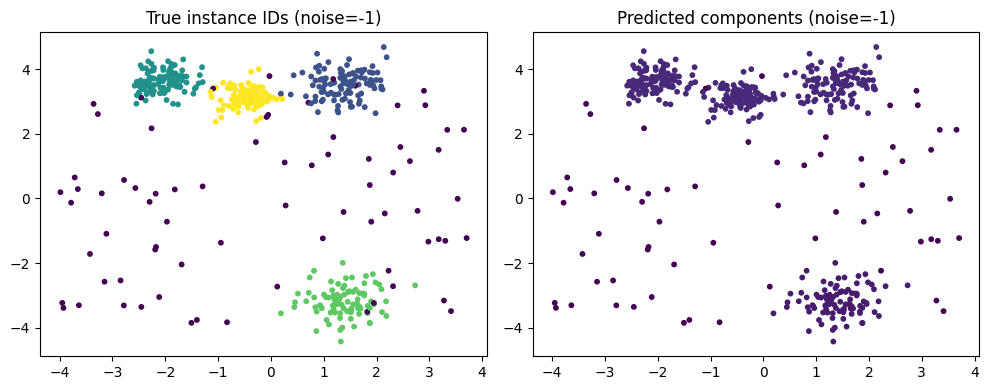

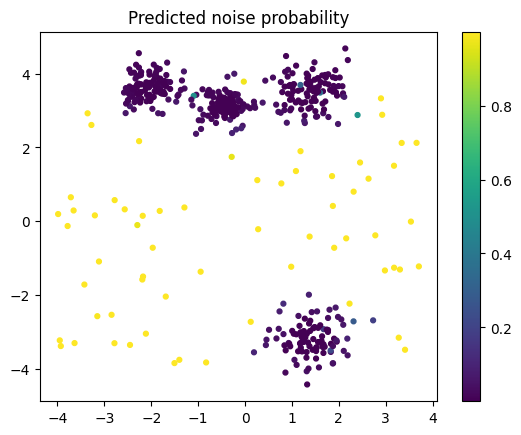

In [10]:
@torch.no_grad()
def predict_event_components(model, data, edge_thresh=0.6, noise_thresh=0.5):
    data = data.clone()
    data.x = (data.x.float() - x_mean) / x_std
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

    data = data.to(device)
    z, edge_index, edge_logits, noise_logits = model(data)

    edge_prob = torch.sigmoid(edge_logits)
    noise_prob = torch.sigmoid(noise_logits)

    comp = connected_components_from_edges(data.num_nodes, edge_index, edge_prob, thresh=edge_thresh)

    comp = comp.astype(np.int64)
    comp[noise_prob.detach().cpu().numpy() > noise_thresh] = -1
    return comp, noise_prob.detach().cpu().numpy()

sample = make_blob_event_instance(n_points=500, n_clusters=4, noise_frac=0.15, seed=12345)
true_cid = sample.cid.numpy()
xy = sample.x[:, :2].numpy()

pred_comp, noise_prob = predict_event_components(model, sample, edge_thresh=0.6, noise_thresh=0.5)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(xy[:,0], xy[:,1], c=true_cid, s=10)
plt.title("True instance IDs (noise=-1)")

plt.subplot(1,2,2)
plt.scatter(xy[:,0], xy[:,1], c=pred_comp, s=10)
plt.title("Predicted components (noise=-1)")

plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(xy[:,0], xy[:,1], c=noise_prob, s=12)
plt.title("Predicted noise probability")
plt.colorbar()
plt.show()
